In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging, os, pickle, scipy, copy, shutil, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import astropy.units as u
import astropy.constants as const
from scipy.integrate import quad

In [3]:
logging.getLogger().setLevel('DEBUG')
logging.getLogger('matplotlib').setLevel('WARNING')
logger = logging.getLogger('main')

In [ ]:
from flarestack.shared import name_pickle_output_dir, unblinding_output_path, unbliding_dir, limit_output_path, plot_output_dir
from flarestack.cosmo.icecube_diffuse_flux import get_diffuse_flux_at_100TeV, get_diffuse_flux_at_1GeV
from flarestack.cosmo import get_diffuse_flux_contour
from flarestack.analyses.ccsn import get_sn_color
# from flarestack.analyses.ccsn.stasik_2017.pre_trial_pvalues import stasik_pre_trial_pvalues
from flarestack.analyses.ccsn.necker_2019.ccsn_helpers import sn_cats, sn_time_pdfs, sn_times, get_population_flux
from flarestack.analyses.ccsn.necker_2019.ccsn_rate import get_ccsn_rate_type_function
# from flarestack.analyses.ccsn.necker_2019.unblinding_scripts.unblind_updated_ccsn import name_root, bkg_ts_root
from flarestack.analyses.ccsn.necker_2019.unblinding_scripts.energy_range.energy_range import energy_range_filename
from flarestack.analyses.ccsn.necker_2019.unblinding_scripts.p_value_distribution.generate_background_pvalue_distribution_single import \
    base_raw, gammas, p_value_filename_single, p_value_directory, p_value_filename

In [ ]:
name_root = "analyses/ccsn/necker_2019/unblind_ccsn"

In [7]:
name_root = "analyses/ccsn/necker_2019/unblind_ccsn"

In [8]:
energy_range_filename

'/Users/jannisnecker/flarestack__data/storage/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/energy_range.pkl'

Set unified plotting style

In [9]:
axis_label_fs = 12
axis_ticks_fs = 10
legend_fs = 12
title_fs = 14
figsize = (5.85, 3.6154988341868854)
preliminary_color = 'red'
preliminary_fs = 30
preliminary_txt = 'IceCube\nPreliminary'

Directory for paper plots

In [10]:
paper_ccsn_plot_dir = plot_output_dir("analyses/ccsn/necker_2019/paper")
logger.info(f'Plots can be found in {paper_ccsn_plot_dir}')

INFO:main:Plots can be found in /Users/jannisnecker/flarestack__data/output/plots/analyses/ccsn/necker_2019/paper


# Energy Limits

In [11]:
def energy_integral(Elow, Ehigh, gamma):
    Elow_gev = Elow.to("GeV").value
    Ehigh_gev = Ehigh.to("GeV").value
    
    if gamma == 2:
        integral = np.log(Ehigh_gev) - np.log(Elow_gev)
        
    else:
        
        def integrand(E):
            return E ** (1 - gamma)
        
        integral, integral_e = quad(integrand, Elow_gev, Ehigh_gev)
        
    return integral

Murase et al. (2011) (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.84.043003)

In [12]:
n_sh = 1e11 * (u.cm ** (-3))
R_sh = 10**(15.5) * u.cm
Delta_R_sh = R_sh
u_ej = 1e4 * u.km / u.s
E_ej = 1e51*u.erg

epsilon_standard = 0.1 
E_ej_standard = 1e51 * u.erg
lum_dist_standard = 10 * u.Mpc


def murase_lim(epsilon=0.1, f_pp=1, E_ej=E_ej, Elow=1e2*u.GeV, Ehigh=1e7*u.GeV, gamma=2):
    fluence = 6e-2 * u.GeV / (u.cm**2) * epsilon / epsilon_standard * min((f_pp, 1)) * E_ej / E_ej_standard * lum_dist_standard ** 2
    area = 4 * np.pi
    tot_energy = fluence * area * energy_integral(Elow, Ehigh, gamma)
    return tot_energy.to('erg')


murase_lim(gamma=2.)

<Quantity 1.32421436e+49 erg>

/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_18442/2756727713.py:4: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale("LOG")


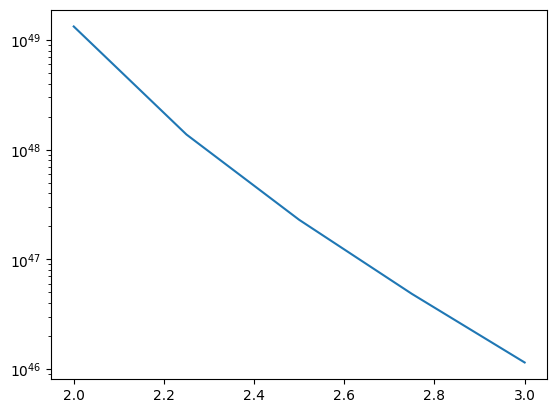

In [13]:
gs = np.linspace(2, 3, 5)
lims = [murase_lim(gamma=g) for g in gs]
plt.plot(gs, u.Quantity(lims).to("erg").value)
plt.yscale("LOG")
plt.show()

In [14]:
a = 6e-2 * u.GeV / (u.cm**2) * lum_dist_standard ** 2 * 4 * np.pi
a.to('GeV').value * 0.0016021773

1.1501984529259554e+48

In [15]:
np.log(1e7) - np.log(1e2)

11.512925464970229

ptuskin et al. (2016) (httplum_dist_standard//doi.org/10.1016/j.astropartphys.2016.02.004)

In [16]:
particle_mass_csm = const.m_p
V_CSM = 4/3 * np.pi * ((R_sh )**3 - (R_sh - Delta_R_sh)**3)
M_CSM = V_CSM * n_sh * particle_mass_csm
print('csm mass [M_sol]', M_CSM / const.M_sun)

u_w_standard = 100 * u.km / u.s
M_dot = M_CSM / Delta_R_sh * u_w_standard
print('mass loss rate [M_sol / yr]', (M_dot / const.M_sun).to('yr-1').value)

M_ej = 2 * E_ej / (u_ej ** 2)
print('ejecta mass [M_sol]', (M_ej.to('kg') / const.M_sun.to('kg')))

M_dot_standard = 1e-2 * const.M_sun / u.yr
E_SN_standard = 1e52 * u.erg
M_ej_standard = 10 * const.M_sun
integration_time = 1e7 * u.s


def t_pp(M_dot=M_dot, u_w=u_w_standard, E_SN=E_ej_standard, M_ej=M_ej):
    f_Mdot = M_dot / M_dot_standard
    f_w = u_w_standard / u_w
    f_E = (E_SN / E_SN_standard) ** (3/2)
    f_Mej = (M_ej / M_ej_standard) ** (-3/2)
    
    t_pp = 0.2*u.yr * f_Mdot * f_w * f_E * f_Mej
    return t_pp


def f_E_nu(
    t_pp_v=0.2*u.yr, 
    M_dot=M_dot, 
    u_w=u_w_standard, 
    E_SN=E_ej_standard, 
    M_ej=M_ej, 
    epsilon=0.1, 
    int_time=integration_time,
    Elow=1e2*u.GeV,
    Ehigh=1e7*u.GeV,
    gamma=2
):
    
    if isinstance(t_pp_v, type(None)):
        t_pp_v = t_pp(M_dot=M_dot, u_w=u_w_standard, E_SN=E_ej_standard, M_ej=M_ej)
    
    t_pp_s = t_pp_v.to('s').value
    
    f = 1e-8 * u.erg / (u.cm**2 * u.s) * u.Mpc**2 * epsilon * (t_pp_v / (0.2*u.yr)) * 4 * np.pi
    f_erg_s = f.to('erg s-1').value
    
    def integrand(t):
        return f_erg_s / (1 + t/t_pp_s)
    
    integral, e = quad(integrand, 0, int_time.to('s').value)
    
    return integral * u.erg * energy_integral(Elow, Ehigh, gamma)


f_E_nu()

csm mass [M_sol] 11.142444611026786
mass loss rate [M_sol / yr] 1.1119479307146483
ejecta mass [M_sol] 1.0058288431740083


<Quantity 8.25511875e+48 erg>

In [17]:
td = 0.2*u.yr
f_E_nu(t_pp_v=td, int_time=30*u.yr)

<Quantity 4.36213332e+49 erg>

In [18]:
30/0.2

150.0

DEBUG:main:IIn


ValueError: 'yerr' (shape: (3, 1)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (3, 1))

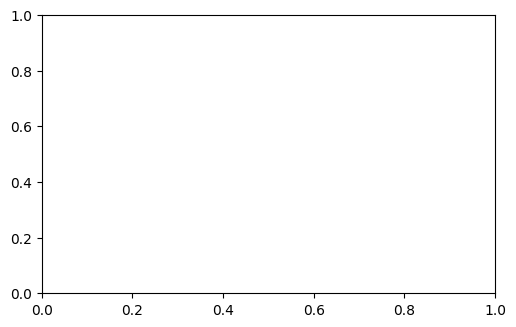

In [24]:
for gamma in [2, 2.5]:

    for pdf_type in ['decay', 'box']:

        fig, ax = plt.subplots(figsize=figsize)

        for cat in sn_cats:
            logger.debug(cat)
            
            try:
                llh_times = sn_time_pdfs(cat, pdf_type=pdf_type)
            except KeyError:
                continue
            
            name = f'{name_root}/{pdf_type}/{cat}'

            x = list()
            y = list()

            for llh_time in llh_times:
                time = llh_time['decay_time'] if 'decay' in pdf_type else \
                    llh_time['pre_window'] + llh_time['post_window']
                full_name = f'{name}/{time}/'

                limit_path = limit_output_path(full_name + "real_unblind/")
                with open(limit_path, 'rb') as f:
                    limits = pickle.load(f)

                ind = np.array(limits['gamma']) == gamma
                y.append(np.array(limits['energy'])[ind])

                if pdf_type == 'box':
                    x.append(time)
                else:
                    x.append(time / 364.25)

            ax.errorbar(x, y, yerr=np.array(y)*1e-1, uplims=4, 
                        color=get_sn_color(cat), ls='', capsize=4, label=cat, marker='_', markersize=10)
            
            
            print(pdf_type, cat)
            print(x, y)
            
        if pdf_type == 'box':
            ts = [t.to('d').value for t in [1e7*u.s, 10**(7.8)*u.s]]
            Es = [murase_lim().to('erg').value for _ in range(len(ts))]
            ax.scatter(ts, Es, marker='s', s=40, color=get_sn_color('IIn'), label='Murase et al. (2011)')
            
        if pdf_type == 'decay':
            td = 0.2*u.yr
            E = f_E_nu(t_pp_v=td, int_time=30*u.yr).to('erg').value
#             E_stand = f_E_nu(M_dot=M_dot_standard, u_w=u_w_standard, E_SN=E_SN_standard, M_ej=M_ej_standard).to('erg').value
            ax.scatter(td, E, marker='D', s=40, label='Zirakashvili & Ptuskin (2016)', color=get_sn_color('IIn'))
#             ax.scatter(t, E_stand, marker='d', s=40, label=' with standard parameters', color=get_sn_color("IIn"))
            
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks(x)
        ax.set_xticklabels(x)
        ax.tick_params(axis='x', labelsize=axis_ticks_fs)
        ax.tick_params(axis='y', labelsize=axis_ticks_fs)
#         xlim = ax.get_xlim()
#         ax.set_xlim((min(xlim) * 0.1, max(xlim)))
        ylim = (1e48, 5e50) if gamma == 2 else (1e48, 5e51)
        ax.set_ylim(ylim)
        ax.legend(fontsize=legend_fs, loc='upper center', ncol=2)
        ax.grid()
        
        unit = "y" if pdf_type == 'decay' else "d"
        xlabel = "Box function $\Delta$T [d]" if pdf_type == 'box' else "Decay time $t_{\mathrm{pp}}$ [y]"
        ax.set_xlabel(xlabel, fontsize=axis_label_fs)
        ax.set_ylabel(r"$E^{\nu} _{\mathrm{tot}}$ [erg]", fontsize=axis_label_fs)
        #ax.set_title(f"$\gamma$ = {gamma:.2f}", fontsize=title_fs)
        
#         ax.annotate(preliminary_txt,
#                     color=preliminary_color, 
#                     fontsize=preliminary_fs,
#                     xy=(0.99, 0.03), xycoords='axes fraction',
#                     horizontalalignment='right', verticalalignment='bottom')
        
        filename = os.path.join(paper_ccsn_plot_dir, "limits", f"{gamma:.2f}", f"SensModels{pdf_type.capitalize()}Small.pdf")
        d = os.path.dirname(filename)
        if not os.path.isdir(d):
            os.makedirs(d)
            
        logger.info(f"saving under {filename}")
        fig.savefig(filename)
        
        plt.show()
        plt.close()

# Contribution to diffuse flux

In [25]:
z = 8  # redshift integration

In [26]:
def plot_diffuse_flux_measurement(axes, **kwargs):
    fit = kwargs.get('fit', 'joint_15')
    contour = kwargs.get('contour', '95')
    color = kwargs.get('color', 'k')
    label = kwargs.get('label', fit)
    best_f, upper_f, lower_f, e_range = get_diffuse_flux_contour(fit=fit, contour_name=contour)
    logging.debug('plotting diffuse flux measurement')
    patch = axes.fill_between(e_range,
                              y1=lower_f(e_range) * e_range ** 2,
                              y2=upper_f(e_range) * e_range ** 2,
                              label=f"{contour}% contour" if label else '', color=color, alpha=0.5)
    line = axes.plot(e_range, best_f(e_range) * e_range ** 2, label=f'{label} best fit' if label else '', color=color)
    return axes, patch, line

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
DEBUG:root:plotting diffuse flux measurement
DEBUG:main:energy is 1.703621708586203e+48
INFO:root:Loaded evolution 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded rate 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded kcc 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:No specified sn_subclass_fractions_name. Assuming default.
INFO:root:Loaded SN subclass fractions 'li_11' (https://arxiv.org/abs/1006.4612)
INFO:root:Subclass 'Ibc' is equal to 24.50% of the CCSN rate.
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_18442/3015290188.py:48: FutureWarning: The frame.append method is deprecated and will be removed from p

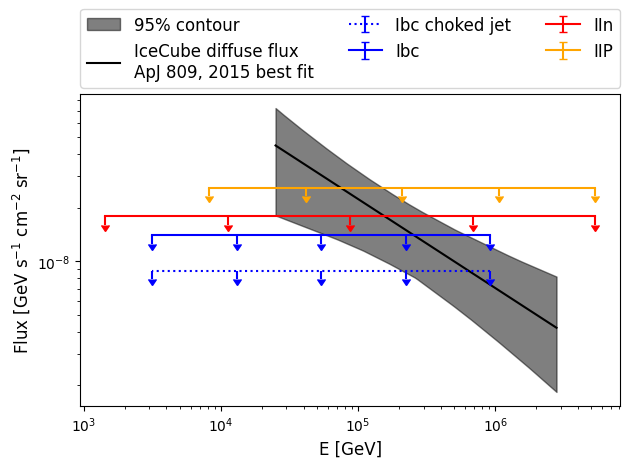

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
DEBUG:root:plotting diffuse flux measurement
DEBUG:main:energy is 4.455661408623348e+48
INFO:root:Loaded evolution 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded rate 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded kcc 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:No specified sn_subclass_fractions_name. Assuming default.
INFO:root:Loaded SN subclass fractions 'li_11' (https://arxiv.org/abs/1006.4612)
INFO:root:Subclass 'Ibc' is equal to 24.50% of the CCSN rate.


                perc_100TeV  perc_1GeV
Ibc choked jet     0.395136   0.001250
Ibc                0.624473   0.001975
IIn                0.797909   0.002523
IIP                1.160759   0.003671


INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_18442/3015290188.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contrib = contrib.append(
DEBUG:main:energy is 8.116413920129238e+48
INFO:root:Loaded evolution 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded rate 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:Loaded kcc 'strolger_15' (https://arxiv.org/abs/1509.06574)
INFO:root:No specified sn_subclass_fractions_name. Assuming default.
INFO:root:Loaded SN subclass fractions 'li_11' (https://arxiv.org/abs/1006.4612)
INFO:root:Subclass 'Ibc' is equal to 24.50% of the CCSN rate.
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' f

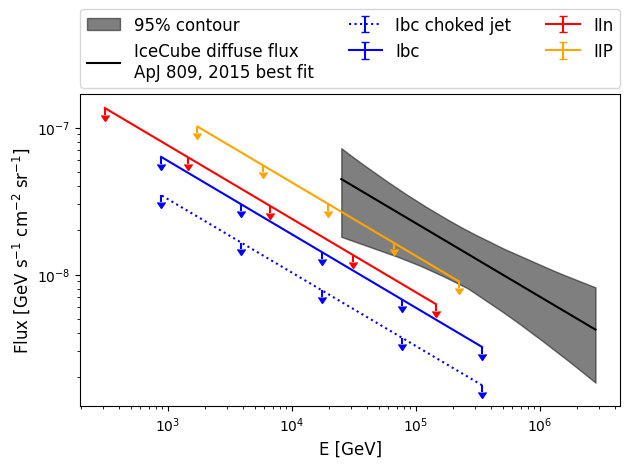

                perc_100TeV  perc_1GeV
Ibc choked jet     0.146010   0.146010
Ibc                0.265972   0.265972
IIn                0.339051   0.339051
IIP                0.599312   0.599312


In [27]:
for gamma in [2, 2.5]:
    energy_dict = {
        'Ibc choked jet': f'{name_root}/box/Ibc/20',
        'Ibc': f'{name_root}/box/Ibc/100',
        'IIn': f'{name_root}/box/IIn/1000',
        'IIP': f'{name_root}/box/IIP/100'
    }

    with open(energy_range_filename, "rb") as f:
        e_range = pickle.load(f)

    e_range_dict = {
        'Ibc': e_range[gamma]['box']['Ibc'],
        'IIn': e_range[gamma]['box']['IIn'],
        'IIP': e_range[gamma]['box']['IIP']
    }

    fig, ax = plt.subplots()

    ax, p, l = plot_diffuse_flux_measurement(
        ax, 
        label="IceCube diffuse flux \nApJ 809, 2015", 
        fit='joint_15'
    )
#     ax, p, l = plot_diffuse_flux_measurement(ax, label="Northern Tracks '19", fit='northern_tracks_19', color='grey')
    
    contrib = pd.DataFrame()
    for icat, pat in energy_dict.items():

        cat = icat if 'Ibc' not in icat else 'Ibc'
        
        limit_path = limit_output_path(pat + "/real_unblind/")
        with open(limit_path, 'rb') as f:
            limits = pickle.load(f)

        ind = np.array(limits['gamma']) == gamma
        energy = float(np.array(limits['energy'])[ind])
        
        logger.debug(f"energy is {energy}")

        energy_range_gev = np.logspace(np.log10(e_range_dict[cat][0]), np.log10(e_range_dict[cat][1]), 5)
#        energy_kwargs = {'e_min_gev': min(energy_range_gev), 'e_max_gev': max(energy_range_gev)}
        pop_flux = get_population_flux(energy * u.erg, get_ccsn_rate_type_function(cat), gamma, z)
        flux_time_esquared = pop_flux * energy_range_gev ** (-1 * gamma + 2) # * energy_range_gev ** 2
        perc = pop_flux * 1e5 ** (-1 * gamma) / get_diffuse_flux_at_100TeV()[0]
        perc_1GeV = pop_flux / get_diffuse_flux_at_1GeV()[0]
        
        contrib = contrib.append(
            pd.DataFrame([[perc.value, perc_1GeV.value]], columns=['perc_100TeV', 'perc_1GeV'], index=[icat])
        )

        ls = '-' if 'choked jet' not in icat else ':'
        ax.errorbar(energy_range_gev, flux_time_esquared.value, yerr=.1* flux_time_esquared.value, 
                    uplims=True, color=get_sn_color(cat), 
#                     label=f"{icat}: {perc*100:.2f}% @100 TeV", 
                    label=icat,
                    ls=ls)

#     ax.legend(fontsize=legend_fs, ncol=3)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=3, 
               mode='expand', fontsize=legend_fs, borderaxespad=0.)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E [GeV]', fontsize=axis_label_fs)
    ax.set_ylabel('Flux [GeV s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=axis_label_fs)
    ax.tick_params(axis='x', labelsize=axis_ticks_fs)
    ax.tick_params(axis='y', labelsize=axis_ticks_fs)
#     ax.annotate(preliminary_txt, color=preliminary_color, fontsize=preliminary_fs,
#                 xy=(0.01, 0.02), xycoords='axes fraction',
#                 horizontalalignment='left', verticalalignment='bottom')
    fig.tight_layout()
#     xlim_high = ax.get_xlim()[-1]
#     ax.set_xlim((1e2, xlim_high))

    filename = os.path.join(paper_ccsn_plot_dir, "limits", f"{gamma:.2f}", f"DiffuseFlux.pdf")
    d = os.path.dirname(filename)
    if not os.path.isdir(d):
        os.makedirs(d)

    logger.info(f"saving under {filename}")
    fig.savefig(filename)

    plt.show()
    plt.close()
    
    print(contrib)

# LaTex

In [53]:
from flarestack.analyses.ccsn.necker_2019.unblinding_scripts.unblind_updated_ccsn import name_root as ccsn_name_root
result_filename = os.path.join(unbliding_dir, ccsn_name_root, 'pre_trial_pvalues.csv')
res = pd.read_csv(result_filename, index_col=0)

In [106]:
txt = ""
for i, l in res.iterrows():
    txt += l.catalogue + " & "
    for n in list(l)[1:]:
        if np.isnan(n):
            txt += "  -  & "
        elif n <= 0.5:
            txt += f"{n*100:4.1f} & "
        else:
            txt += f" $>$50 & "
    txt = txt[:-2]
    txt += "\\\\ \n"
    
print(txt)

fn = os.path.join(paper_ccsn_plot_dir, "p-values.tex")
print(f"saving under {fn}")
with open(fn, "w") as f:
    f.write(txt)

IIn &   -  &  8.6 &  6.3 &  $>$50 &  $>$50 &  $>$50 & 30.1 \\ 
IIP &   -  & 48.6 &  $>$50 & 27.6 &  $>$50 &  $>$50 & 21.6 \\ 
Ibc &  $>$50 &  $>$50 &  $>$50 & 34.8 &   -  &   -  &   -  \\ 

saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/ccsn/necker_2019/paper/p-values.tex


# Differential Sensitivity

In [163]:
diferential_sens_fn = "/afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/differential_sens.pkl"

with open(diferential_sens_fn, "rb") as f:
    differential_sens = pickle.load(f)

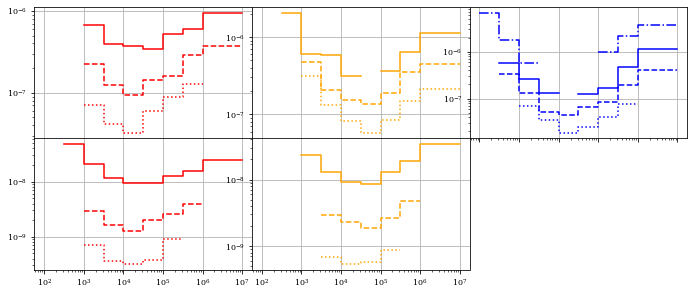

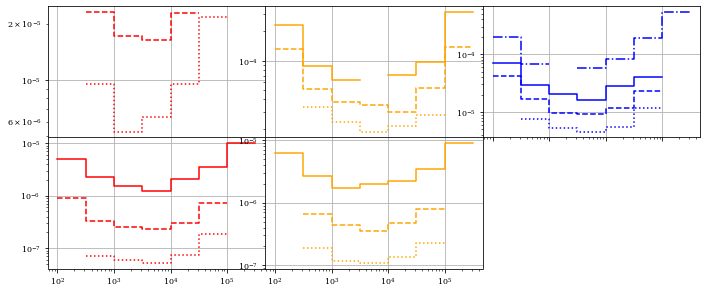

In [169]:
ls = ["-", "--", ":", "-."]


for gamma in [2, 2.5]:
    fig, axs = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(5.85 * 3 / 1.5, 3.6154988341868854 * 2 / 1.5),
        gridspec_kw={"hspace": 0, "wspace": 0},
        sharex="all",
#         sharey="all",
    )
    for i, (pdf_type, sn_dict) in enumerate(differential_sens.items()):
        for j, (sn_type, time_dict) in enumerate(sn_dict.items()):
            for k, (time, gamma_dict) in enumerate(time_dict.items()):
                
                energies = list()
                sensitivities = list()
                
                for erange_name, s in gamma_dict[gamma].items():
#                     print(erange_name, s)
                    if len(s):
                        sens, sens_e = s
                    else:
                        sens = np.nan
                        
                    elow_name, ehigh_name = erange_name.split("_")
                    elow = float(elow_name.split("elow")[-1])
                    ehigh = float(ehigh_name.split("ehigh")[-1])


                    if (not len(energies)):
                        energies.append(elow)

                    energies.append(ehigh)
                    sensitivities.append(sens)
                    
                sensitivities.append(sens)
                
                ax = axs[i][j]
                
                ax.step(energies, sensitivities, color=get_sn_color(sn_type), ls=ls[k])
                ax.set_yscale('log')
                ax.set_xscale('log')
                ax.grid('on')
                
    axs[-1][-1].axis('off')

    plt.show()

# Copy files from other storage directory

In [133]:
directories = [
    "storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights",
    "storage/pickles/injection_values/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights"
]

sources = list()
destins = list()

for d in directories:

    src_base = f"/lustre/fs23/group/icecube/necker/flarestack_11102021/flarestack__data/{d}"
    dst_base = f"/afs/ifh.de/group/amanda/scratch/neckerja/fs_dev_branch/flarestack__data/{d}"

    for pdf_type in ["box", "decay"]:
        c = sn_cats if pdf_type == "box" else ["IIn", "IIP"]
        for cat in c:
            time_pdfs = sn_time_pdfs(cat, pdf_type=pdf_type)

            # Loop over time PDFs
            for llh_time in time_pdfs:

                if pdf_type == "box":
                    time_key = str(llh_time["post_window"] + llh_time["pre_window"])
                    pdf_time = (
                        float(time_key)
                        if llh_time["pre_window"] == 0
                        else -float(time_key)
                    )

                else:
                    time_key = str(llh_time["decay_time"])
                    pdf_time = llh_time["decay_time"] / 364.25

                for g in ["2", "2.5"]:

                    src_dir = f"{src_base}/{pdf_type}/{cat}/{time_key}/{g}/"

                    if g == "2" and not os.path.exists(src_dir):
                        g = "2.0"
                        src_dir = "/" + src_dir.strip("2/") + "/2.0/"

                    dst_dir = f"{dst_base}/{pdf_type}/{cat}/{time_key}/{g}/"

                    for f in os.listdir(src_dir):

                        src = f"{src_dir}{f}"
                        dst = f"{dst_dir}{f}"
                        
                        sources.append(src)
                        destins.append(dst)

print(f"copying {len(sources)} files")

for src, dst in tqdm.tqdm(zip(sources, destins), total=len(sources)):
    #print(f"\ncopy \n{src} \nto \n{dst}")

    dst_d = os.path.dirname(dst)
    if not os.path.isdir(dst_d):
        print(f"making {dst_d}")
        os.makedirs(dst_d)
    
    if os.path.isfile(src):
        shutil.copy(src, dst)
    if os.path.isdir(src):
        try:
            shutil.copytree(src, dst)
        except shutil.Error as exc:
            errors = exc.args[0]
            for error in errors:
                src, dst, msg = error
                #print("\n\n====================================\n", src, dst, msg, "\n\n")
            continue
        except FileExistsError:
#             print(f"{dst}\n-----> File exists!")
            continue
            
        print("copied!")

  0%|          | 0/778 [00:00<?, ?it/s]

copying 778 files


100%|██████████| 778/778 [00:02<00:00, 319.49it/s]


In [114]:
d

'storage/pickles/injection_values/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights'

In [40]:
src_dir.strip("/2.0/") == d

False

In [38]:
d = '/afs/ifh.de/user/n/neckerja/lustre/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/100'
os.listdir(d)

['2.5', '2.0']

In [47]:
d = '/afs/ifh.de/user/n/neckerja/scratch/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/100/2.0/'
os.listdir(d)

['103.7']

In [41]:
d

'/afs/ifh.de/user/n/neckerja/lustre/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/100'

In [43]:
src_dir.strip("/2.0/")

'afs/ifh.de/user/n/neckerja/lustre/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/1'

In [44]:
src_dir

'afs/ifh.de/user/n/neckerja/lustre/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/100/2.0/'

In [63]:
src

'/afs/ifh.de/user/n/neckerja/lustre/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIP/100/2.0/e_min_gev'

In [64]:
dst

'/afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIP/100/2.0/e_min_gev'

In [65]:
cmd = f"cp -r {src_dir} {dst_dir}"
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
tmp = process.stdout.read().decode()
print(tmp)

In [70]:
os.mkdir("hello")

In [71]:

os.mkdir("hello/shit")

In [72]:
os.mkdir("hello2")

In [74]:
shutil.copytree("hello", "hello2/hello")

'hello2/hello'

In [76]:
os.listdir("hello2/hello")

['shit']

In [77]:
with open("hello/shit/txt.txt", "w") as f:
    f.write("fuck")

In [78]:
shutil.rmtree("hello2/hello")

In [79]:
os.mkdir("hello2/hello")

In [80]:
shutil.copytree("hello/shit", "hello2/hello/shit")

'hello2/hello/shit'

In [135]:
f = "/afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/merged/0.pkl"
#f = "/lustre/fs23/group/icecube/necker/flarestack_11102021/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/merged/0.pkl"

with open(f, "rb") as f:
    dat = pickle.load(f)
    


In [136]:
dat.keys()

dict_keys(['TS', 'Parameters', 'Flags'])

In [107]:
from flarestack.utils.custom_dataset import custom_dataset
from flarestack.data.icecube import ps_v002_p03
from flarestack.core.results import ResultsHandler
import tqdm

In [123]:
name = "analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0"
cat_path = "/afs/ifh.de/user/n/neckerja/flarestack/flarestack/analyses/ccsn/necker_2019/catalogues/IIn.npy"
catalogue = np.load(cat_path)


mh_dict = {
    "name": name,
    "mh_name": "fit_weights",
    "dataset": custom_dataset(
        ps_v002_p03, catalogue, {
            "time_pdf_name": "box",
            "pre_window": 0,
            "post_window": 300
        }
    ),
    "catalogue": cat_path,
    "inj_dict": {
        "injection_energy_pdf": {
            "energy_pdf_name": "power_law",
            "gamma": 2.0,
            "e_min_gev": 100.0,
            "e_max_gev": 316.22776601683796
        },
        "injection_sig_time_pdf": {
            "time_pdf_name": "box",
            "pre_window": 0,
            "post_window": 300
        },
        "poisson_smear_bool": True
    },
    "llh_dict": {
        "llh_name": "standard",
        "llh_energy_pdf": {
            "energy_pdf_name": "power_law"
        },
        "llh_sig_time_pdf": {
            "time_pdf_name": "box",
            "pre_window": 0,
            "post_window": 300
        },
        "llh_bkg_time_pdf": {
            "time_pdf_name": "steady"
        }
    },
    "scale": 16530.0,
    "n_trials": 10,
    "n_steps": 10,
    "allow_extrapolated_sensitivity": False,
    "background_ntrials_factor": 0
}




In [124]:
rh = ResultsHandler(mh_dict, do_disc=False, do_sens=False)

DEBUG:flarestack.core.results:Did not load /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/injection_values/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/differential_sens, not a file!
DEBUG:flarestack.core.results:Did not load /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/injection_values/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/e_min_gev, not a file!
DEBUG:flarestack.core.results:Did not load /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/injection_values/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/e_max_gev, not a file!
DEBUG:flarestack.core.results:loading merged data from /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/pickles/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/box/IIn/300/2.0/merged/d

SystemExit: 

/afs/ifh.de/user/n/neckerja/scratch/envs/flarestack_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [118]:
rh.scales

['0',
 '1836',
 '3673',
 '5509',
 '7345',
 '9182',
 '1.102E+04',
 '1.285E+04',
 '1.469E+04',
 '1.653E+04']

In [103]:
rh.results['0'].keys()

dict_keys(['TS', 'Parameters', 'Flags'])

In [119]:
rh.inj.keys()

dict_keys(['0', '9182', '1.653E+04', '1.102E+04', '1.469E+04', '3673', '1836', '7345', '1.285E+04', '5509'])